In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_turnbackhoax_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_cnn_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_kompas_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Summarized/dataset_tempo_summarized.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_cnn_10k_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_kompas_4k_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_tempo_6k_cleaned.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/RAW/dataset_kompas_4k.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/RAW/dataset_turnbackhoax_10k.xlsx
/kaggle/input/indonesian-fact-and-hoax-political-news/RAW/dataset_temp

In [3]:
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re, string, unicodedata
import seaborn as sns
import tensorflow as tf

2024-05-17 07:44:36.385628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 07:44:36.385732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 07:44:36.652424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import warnings

# Mengabaikan semua peringatan
warnings.filterwarnings("ignore")

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input

In [6]:
from keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, GRU, Input, Layer, LSTM, BatchNormalization, LayerNormalization
# from keras.models import Model
# from keras.preprocessing.text import Tokenizer
# from keras.src.layers.core.activation import activations
# from nltk.corpus import stopwords
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.initializers import Constant
# from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import to_categorical
# from transformers import BertTokenizer, TFAutoModel
# from keras.models import Model
# from keras.preprocessing.text import Tokenizer
from keras.layers import Activation
from nltk.corpus import stopwords
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [7]:
cnn = '/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_cnn_10k_cleaned.xlsx'
kompas = '/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_kompas_4k_cleaned.xlsx'
hoax = '/kaggle/input/indonesian-fact-and-hoax-political-news/Cleaned/dataset_turnbackhoax_10_cleaned.xlsx'

In [8]:
def excel_to_df(excel):
    df = pd.read_excel(excel, index_col=0)
    # df = df.drop(columns=df.columns[0])
    return df

df_cnn = excel_to_df(cnn)
df_kompas = excel_to_df(kompas)
df_hoax = excel_to_df(hoax)

In [9]:
print("Shape of cnn data: {}".format(df_cnn.shape))
print("Shape of kompas data: {}".format(df_kompas.shape))
print("Shape of hoax data: {}".format(df_hoax.shape))

Shape of cnn data: (9630, 8)
Shape of kompas data: (4750, 8)
Shape of hoax data: (10381, 10)


In [10]:
df_cnn.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,text_new,hoax
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,"Selasa, 21 Feb 2023 21:22 WIB","Jakarta, CNN Indonesia -- Mantan Gubernur DKI ...",anies baswedan;pengajian;pilpres 2024;badan ko...,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,"Selasa, 21 Feb 2023 20:46 WIB","Medan, CNN Indonesia -- Gubernur Sumatera Utar...",edy rahmayadi;pemilu 2024;pilkada 2024,CNN Indonesia,https://www.cnnindonesia.com/nasional/20230221...,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0


In [11]:
df_kompas.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,text_new,hoax
0,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...","21 Februari 2023, 15:30 WIB",Hasil jajak pendapat yang diselenggarakan Litb...,Survei Litbang Kompas;Elektabilitas Nasdem Nai...,NaN,https://video.kompas.com/watch/258152/efek-eko...,"Efek Ekor Jas Pencalonan Anies, Elektabilitas ...",0
1,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...","Kompas.com - 21/02/2023, 14:22 WIB","JAKARTA, KOMPAS.com - Pemerintah menargetkan p...",Jakarta;Ekonomi 2024,Penulis Yohana Artha Uly | Editor Aprillia Ika,http://money.kompas.com/read/2023/02/21/142238...,"Ekonomi 2024 Ditargetkan Tumbuh 5,7 Persen, pa...",0


In [12]:
df_hoax.head(2)

,Title,Timestamp,FullText,Tags,Author,Url,politik,Narasi,Clean Narasi,hoax
0,[SALAH] Anies Baswedan Dekat Dengan Aliran Krs...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-anies...,1,\n“BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU...,BISA DILIHAT SI ONTA YAMAN NGGAK PEDULI ITU AP...,1
1,[SALAH] Hakim Wahyu Iman Santoso Alami Kecelak...,"Maret 1, 2023",Hasil Periksa Fakta Gabriela Nauli Sinaga (Uni...,Fitnah;Hasut;Hoax,Pemeriksa Fakta Junior,https://turnbackhoax.id/2023/03/01/salah-hakim...,0,\n“ini bener gasih?? Ya Allah gimna keadaan pa...,ini bener gasih?? Ya Allah gimna keadaan pa ha...,1


In [13]:
df_cnn = df_cnn[['text_new','hoax']]
df_kompas = df_kompas[['text_new','hoax']]
df_hoax = df_hoax[['Clean Narasi','hoax']]

df_cnn = df_cnn.rename(columns = {'text_new':'text'})
df_kompas = df_kompas.rename(columns = {'text_new':'text'})
df_hoax = df_hoax.rename(columns = {'Clean Narasi':'text'})

df = pd.concat([df_cnn, df_kompas, df_hoax])
df

,text,hoax
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0
...,...,...
10379,Raja Salman dari arab saudi membawa orang-oran...,1
10380,"hehe, selalu bisa tersenyum melihat tingkah la...",1
10381,Pak Jokowi itu menjadi walikota periode pertam...,1
10382,"Hari ini, Rabu (23/09/2015), nilai tukar rupia...",1


In [14]:
df['hoax'].value_counts()

hoax
0    14380
1    10381
Name: count, dtype: int64

In [15]:
df.isna().sum()

text    3906
hoax       0
dtype: int64

In [16]:
# Drop missing value
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df['hoax'].value_counts()

hoax
0    14353
1     6502
Name: count, dtype: int64

In [18]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['num_char'] = df['text'].apply(lambda x: len(x))
df.head()

,text,hoax,word_count,num_char
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,263,1955
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,281,1927
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,183,1301
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,185,1327
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,200,1467


# Data Filtering

In [19]:
df_pre_new = df.loc[(df['word_count'] >= 20) & (df['word_count'] < 500)]
df_pre_new

,text,hoax,word_count,num_char
0,Anies di Milad BKMT: Pengajian Menghasilkan Ib...,0,263,1955
1,Edy Soal Pilgub Sumut: Kalau yang Maju Abal-ab...,0,281,1927
2,PKB Bakal Daftarkan Menaker Ida Fauziyah Jadi ...,0,183,1301
3,Gede Pasek Doakan AHY Jadi Capres atau Cawapre...,0,185,1327
4,PKN Siapkan Jabatan Khusus Buat Anas Urbaningr...,0,200,1467
...,...,...,...,...
20848,PAS KAMPANYE ada warning dugaan PKI bangkit di...,1,66,526
20849,"Pada 16 April lalu, Menteri Perdagangan Rachma...",1,222,1755
20850,Raja Salman dari arab saudi membawa orang-oran...,1,24,150
20852,Pak Jokowi itu menjadi walikota periode pertam...,1,98,617


In [20]:
df_pre_new['hoax'].value_counts()

hoax
0    13761
1     4482
Name: count, dtype: int64

In [21]:
MAX_LEN = 500
SEED = 80

In [22]:
df = df_pre_new[['text', 'hoax']]

In [23]:
df = df.sample(frac = 1, ignore_index=True, random_state=SEED)
df

,text,hoax
0,Mega Disebut Pernah Ancam Pecat Kader PDIP yan...,0
1,"Dikunjungi Gibran, Rocky Gerung Singgung Nasib...",0
2,Kerja Sama dalam Berbagai Bidang Kehidupan Ke...,0
3,"Jalan Politik Gibran, dari Tukang Martabak hin...",0
4,Survei yang beredar itu kami pastikan hoaks. S...,1
...,...,...
18238,LAGU YG TDK DI IZINKAN UTK UMUM..DI HARAMKAN.....,1
18239,Eks Gubernur Sumbar Ungkap Pernah Tolak Beli M...,0
18240,Cerita Zulfan Lindan Telepon Surya Paloh Usai ...,0
18241,Pengamat: Salat Id di JIS Pasti Dimanfaatkan J...,0


# Text Preprocessing

In [24]:
df.iloc[50,0]

'"Agenda Politik Mungkin Gaduh, tapi Dampaknya terhadap Ekonomi Minim Sekali"  Tahun 2018 hingga 2019 merupakan tahun politik bagi Indonesia, yakni ditandai dengan penyelenggaraan pemilihan kepala daerah (pilkada) dan pemilihan presiden (pilpres). Meskipun demikian, gelaran pesta demokrasi tersebut diyakini tidak akan berpengaruh terhadap stabilitas sistem keuangan. Gubernur Bank Indonesia (BI) Agus DW Martowardojo menuturkan, meskipun ketegangan politik cenderung menghangat, namun dampaknya tidak terlalu besar terhadap perekonomian Indonesia secara umum. Hal ini pun telah dialami Indonesia, sejalan dengan panjangnya sejarah pemilihan umum di dalam negeri. "Indonesia selama 10-15 tahun terakhir punya track record (rekam jejak) bahwa kalau kita punya agenda politik mungkin gaduh, tapi dampaknya terhadap ekonomi dan stabilitas sistem keuangan minim sekali," kata Agus saat memberikan kuliah umum di Perbanas Institute, Rabu (21/2/2018). Agus menuturkan, berbekal pengalaman tersebut, maka m

In [25]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk

True

In [26]:
def cleaning(text):
    #remove non-ascii
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    text = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
    #remove punctuations
    text = re.sub(r'[^\w]|_',' ',text)
    #remove digit from string
    text = re.sub("\S*\d\S*", "", text).strip()
    #remove digit or numbers
    text = re.sub(r"\b\d+\b", " ", text)
    #to lowercase
    text = text.lower()
    #Remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    #Replace words
    text = text.replace("yg", "yang")
    #Remove stopwords

    stopword = set(stopwords.words('indonesian'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stopword])

    return text

In [27]:
# mengubah nama kolom
df = df.rename(columns = {'hoax':'labels'})

In [28]:
df['text'] = df['text'].apply(cleaning)

In [29]:
df

,text,labels
0,mega ancam pecat kader pdip interupsi sby ketu...,0
1,dikunjungi gibran rocky gerung singgung nasib ...,0
2,kerja bidang kehidupan kerja gotong royong keh...,0
3,jalan politik gibran tukang martabak daftar wa...,0
4,survei beredar pastikan hoaks merugikan lembag...,1
...,...,...
18238,lagu tdk izinkan utk haramkan mati nya michael...,1
18239,eks gubernur sumbar tolak beli mobil dinas man...,0
18240,cerita zulfan lindan telepon surya paloh dinon...,0
18241,pengamat salat id jis dimanfaatkan panggung po...,0


In [30]:
df.iloc[50,0]

'agenda politik gaduh dampaknya ekonomi minim politik indonesia ditandai penyelenggaraan pemilihan kepala daerah pilkada pemilihan presiden pilpres gelaran pesta demokrasi diyakini berpengaruh stabilitas sistem keuangan gubernur bank indonesia bi agus dw martowardojo ketegangan politik cenderung menghangat dampaknya perekonomian indonesia dialami indonesia sejalan panjangnya sejarah pemilihan negeri indonesia track record rekam jejak agenda politik gaduh dampaknya ekonomi stabilitas sistem keuangan minim agus kuliah perbanas institute rabu agus berbekal pengalaman masyarakat khawatir dampak politik bank sentral kementerian lembaga terkait menjaga kredibilitasnya seandainya dinamika politik jalan bank indonesia lembaga kementerian terkait stabilitas ekonomi terjaga agus indonesia memiliki undang undang uu komite stabilitas sistem keuangan kssk undang undang lembaga bi kementerian keuangan otoritas jasa keuangan ojk lembaga penjamin simpanan lps berupaya menjaga stabilitas sistem keuanga

labels
0    13761
1     4482
Name: count, dtype: int64


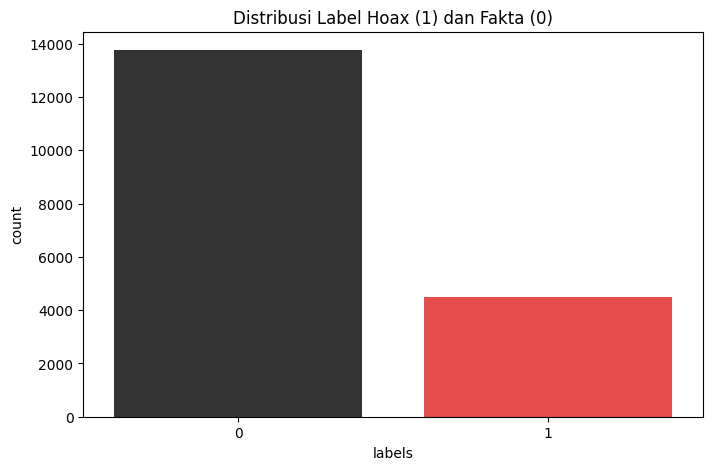

In [31]:
print(df['labels'].value_counts())
plt.figure(figsize=(8, 5))
sns.countplot(x='labels', palette={0: 'black', 1: 'red'}, alpha=0.8, data=df)
plt.title('Distribusi Label Hoax (1) dan Fakta (0)')
plt.show()

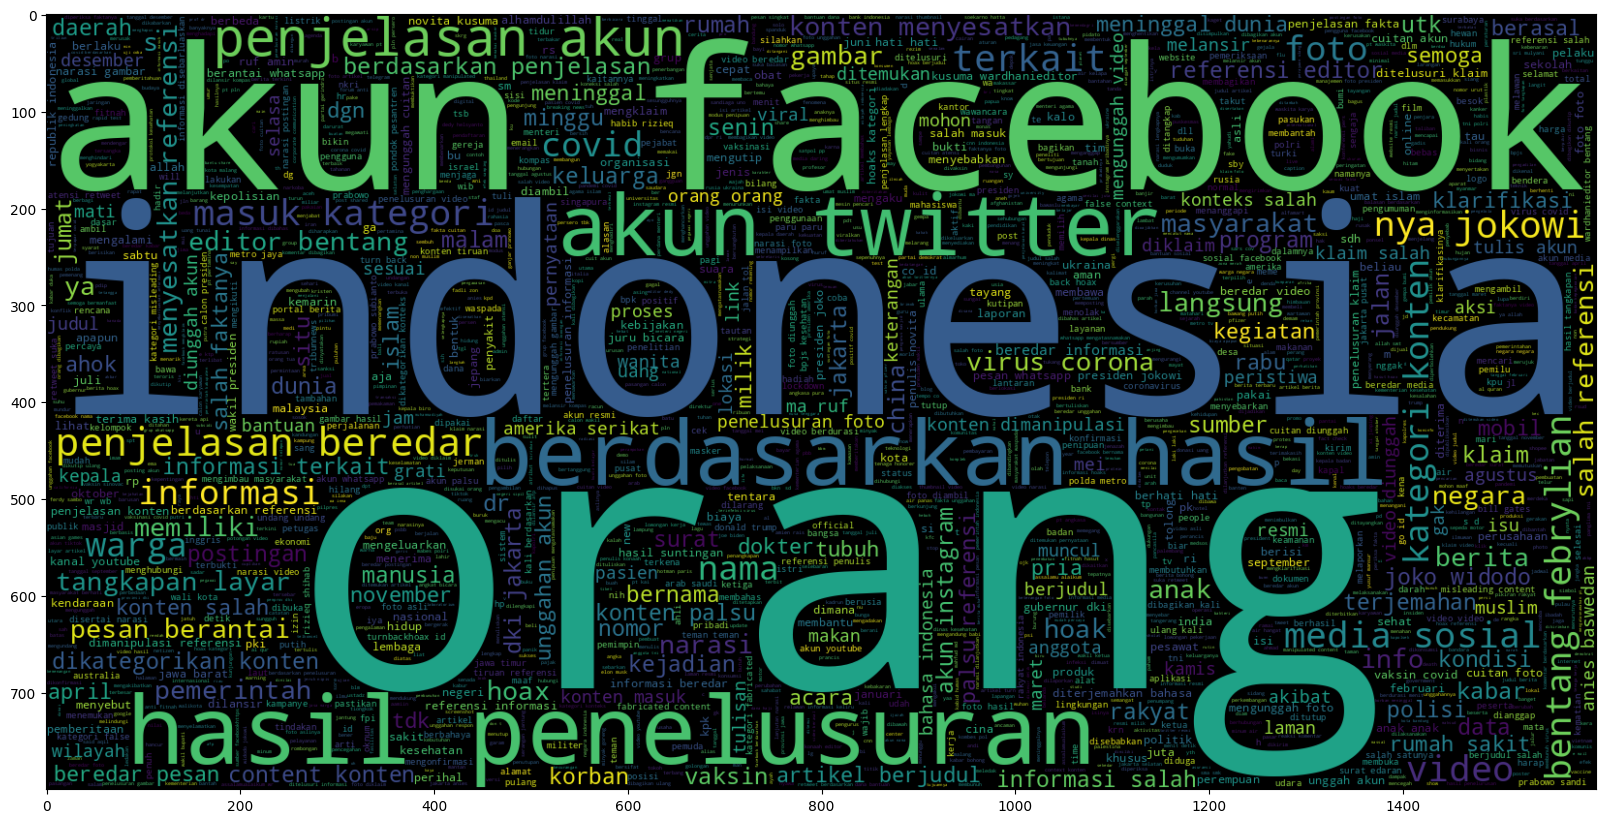

In [32]:
from wordcloud import WordCloud,STOPWORDS
# label 1 untuk hoax
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.labels == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

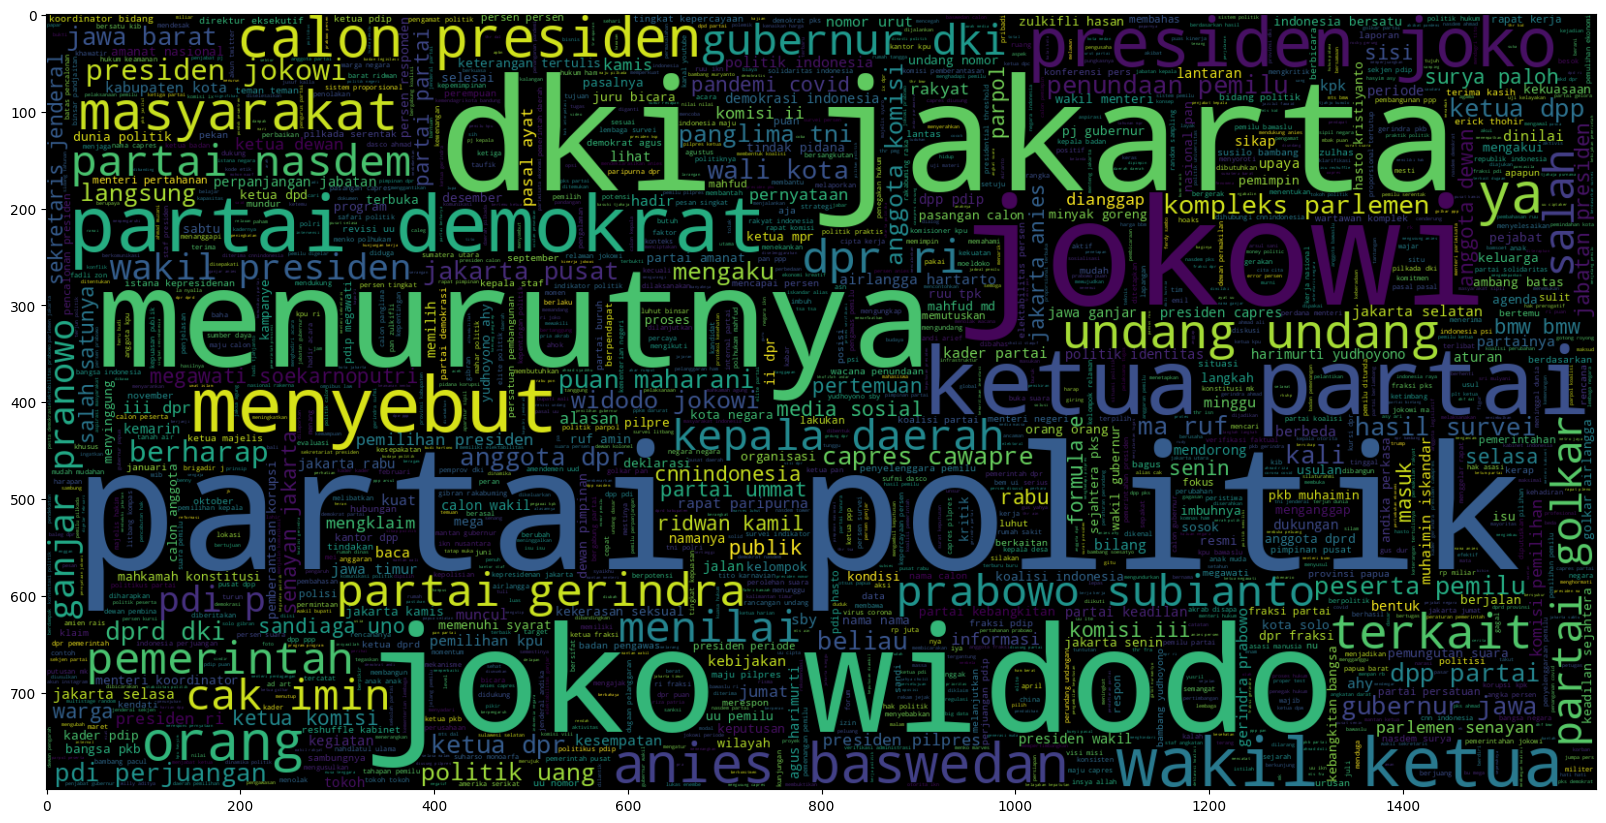

In [33]:
# label 0 untuk valid
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df.labels == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# Data Splitting

In [34]:
X = df['text']
y = df['labels']

In [35]:
#split the train and test data
from sklearn.model_selection import train_test_split
# Pertama, bagi data menjadi train (80% dari data) dan test (20% dari data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Kemudian, bagi X_train lagi untuk membuat validation set (15% dari data asli, ≈18.75% dari X_train)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1875, random_state=42)

In [67]:
#split the train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state=42)

# Tokenizer

In [68]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
tokenizer.word_index

{'partai': 1,
 'politik': 2,
 'presiden': 3,
 'ketua': 4,
 'jokowi': 5,
 'indonesia': 6,
 'pemilu': 7,
 'jakarta': 8,
 'dpr': 9,
 'persen': 10,
 'anies': 11,
 'pemerintah': 12,
 'masyarakat': 13,
 'negara': 14,
 'calon': 15,
 'prabowo': 16,
 'orang': 17,
 'pdip': 18,
 'anggota': 19,
 'wakil': 20,
 'menteri': 21,
 'gubernur': 22,
 'terkait': 23,
 'nasdem': 24,
 'demokrat': 25,
 'daerah': 26,
 'pilpres': 27,
 'nama': 28,
 'salah': 29,
 'capres': 30,
 'gerindra': 31,
 'dki': 32,
 'kota': 33,
 'ganjar': 34,
 'kpu': 35,
 'hasil': 36,
 'komisi': 37,
 'koalisi': 38,
 'undang': 39,
 'kepala': 40,
 'menurutnya': 41,
 'rakyat': 42,
 'memiliki': 43,
 'menyebut': 44,
 'golkar': 45,
 'ri': 46,
 'kader': 47,
 'pks': 48,
 'survei': 49,
 'hukum': 50,
 'jawa': 51,
 'com': 52,
 'rapat': 53,
 'ya': 54,
 'nasional': 55,
 'puan': 56,
 'video': 57,
 'covid': 58,
 'pemilihan': 59,
 'akun': 60,
 'pkb': 61,
 'suara': 62,
 'mengaku': 63,
 'dpp': 64,
 'informasi': 65,
 'rabu': 66,
 'ppp': 67,
 'kerja': 68,
 'jok

In [69]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df

,text,labels,word_count
0,mega ancam pecat kader pdip interupsi sby ketu...,0,148
1,dikunjungi gibran rocky gerung singgung nasib ...,0,202
2,kerja bidang kehidupan kerja gotong royong keh...,0,132
3,jalan politik gibran tukang martabak daftar wa...,0,99
4,survei beredar pastikan hoaks merugikan lembag...,1,167
...,...,...,...
18238,lagu tdk izinkan utk haramkan mati nya michael...,1,144
18239,eks gubernur sumbar tolak beli mobil dinas man...,0,211
18240,cerita zulfan lindan telepon surya paloh dinon...,0,174
18241,pengamat salat id jis dimanfaatkan panggung po...,0,296


In [70]:
# Menampilkan jumlah kata maksimum dalam kolom 'word_count'
max_word_count = df['word_count'].max()
print("Jumlah kata maksimum dalam kolom 'word_count':", max_word_count)

max_index = df['word_count'].idxmax()
print("Pada kolom 'word_count' indeks ke:", max_index)

Jumlah kata maksimum dalam kolom 'word_count': 426
Pada kolom 'word_count' indeks ke: 17611


In [71]:
padding_type = 'post'
truncating_type = 'post'

def get_sequences(tokenizer, text):
  sequences = tokenizer.texts_to_sequences(text)
  padded_sequences = pad_sequences(sequences, truncating='post', maxlen=MAX_LEN, padding='post')
  return padded_sequences

In [72]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  69508


In [73]:
padded_train_sequences = get_sequences(tokenizer, X)
print(padded_train_sequences[17611])

[  451   449    40    26   777  1091   386  1172    21   136  1091   386
  1172  1785   562   449    22   548    66   962  1726   962  1501   449
    40    26   446  4310   449    22  2924   777   386  1172    40    26
  1073   779  3075   562    40    26    22   235    33   274   449    40
    26  1288  2723   435    40    26  2994    36    90   493    90   164
   345   449    40    26    79  1946   451    28   449    40    26   777
  1091   386 68430   131  2865  6997  1474   185  2061   659   488  3827
   126    55  2061  3827  1028   480  7625  1793   729  1028   876   131
  6408  5559   368   138  1763    26   171   136  5172  4482   330 13043
  2716  4389  4778   171  1357   339   684  4389  4547  5053  5505  7628
   419   816   185   694 11385    21   863  1816   548  1809  4310   419
   816  1091   185    50  1687    87    40   126  2574  1108    26   119
    51   131    51 68431  5812 68432 38212 28479    40   511   863  1816
  1431   119    51   145 12288  1736 12982 68433   

In [74]:
classes = set(y)
classes_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_classes = dict((v,k) for k, v in classes_to_index.items())
names_to_ids_training = lambda labels: np.array([classes_to_index.get(X) for X in y])
labels = names_to_ids_training(y)

In [75]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [76]:
labels = label_encoder.transform(labels)

# Sequence and padding

In [77]:
# untuk data train
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = MAX_LEN,
                                padding = padding_type,
                                truncating = truncating_type)

In [78]:
# untuk data validation
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,
                                maxlen = MAX_LEN,
                                padding = padding_type,
                                truncating = truncating_type)

In [79]:
# untuk data test
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = MAX_LEN,
                               padding = padding_type,
                               truncating = truncating_type)

In [80]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of val tensor: ', val_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (14594, 500)
Shape of val tensor:  (1824, 500)
Shape of testing tensor:  (1825, 500)


In [81]:
# Convert the labels lists into numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test =np.array(y_test)

# Model

In [82]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D

# Define parameter
embedding_dim = 512
drop_value = 0.1
# n_dense = 24
# Define Dense Model Architecture
# model = Sequential()
# model.add(Embedding(vocab_size,
#                     embedding_dim,
#                     input_length = MAX_LEN))
# model.add(GlobalAveragePooling1D())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(drop_value))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(drop_value))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(drop_value))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(drop_value))
# model.add(Dense(1, activation='sigmoid'))
# model.compile()

In [83]:
# model.summary()

In [84]:
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [85]:
# from tensorflow.keras.callbacks import EarlyStopping

# num_epochs = 30
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
# history = model.fit(training_padded,
#                     y_train,
#                     epochs=num_epochs, 
#                     validation_data=(val_padded, y_val),
#                     callbacks =[early_stop],
#                     verbose=2)

In [86]:
# import matplotlib.pyplot as plt

# # Plot Utility
# def plot_graphs(history, string):
#   plt.plot(history.history[string])
#   plt.plot(history.history['val_'+string])
#   plt.xlabel("Epochs")
#   plt.ylabel(string)
#   plt.legend([string, 'val_'+string])
#   plt.show()

# # Plot the accuracy and loss history
# plot_graphs(history, 'accuracy')
# plot_graphs(history, 'loss')

In [87]:
# from keras.layers import Reshape
# drop_lstm = 0.5 

# model2 = Sequential()
# model2.add(Embedding(vocab_size,
#                      embedding_dim,
#                      input_length = MAX_LEN))
# # model.add(Reshape((MAX_LEN, embedding_dim)))  # Menambahkan lapisan Reshape
# model2.add(Bidirectional(LSTM(512, return_sequences = False)))
# model2.add(Dropout(drop_lstm))
# model2.add(Bidirectional(LSTM(256, return_sequences = False)))
# model2.add(Dropout(drop_lstm))
# model2.add(Dense(512, activation='relu'))
# model2.add(Dense(256, activation='relu'))
# model2.add(Dense(128, activation='relu'))
# model2.add(Dense(64, activation='relu'))
# model2.add(Dense(1, activation='sigmoid'))

# model2.summary()

In [88]:
# from keras.models import Model
# from keras.layers import Input, Dropout, Embedding, LSTM, Bidirectional, Dense, GlobalMaxPooling1D

# drop_lstm = 0.5

# # Define input layer
# input_layer = Input(shape=(MAX_LEN,))

# # Build model2
# embedding_layer = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(input_layer)
# lstm1 = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
# lstm2 = Bidirectional(LSTM(128, return_sequences=True))(lstm1)
# global_max_pooling = GlobalMaxPooling1D()(lstm2)
# dense1 = Dense(512, activation='relu')(global_max_pooling)
# dense1_dropout = Dropout(drop_lstm)(dense1)
# dense2 = Dense(256, activation='relu')(dense1_dropout)
# dense2_dropout = Dropout(drop_lstm)(dense2)
# dense3 = Dense(128, activation='relu')(dense2_dropout)
# dense3_dropout = Dropout(drop_lstm)(dense3)
# dense4 = Dense(64, activation='relu')(dense3_dropout)
# dense4_dropout = Dropout(drop_lstm)(dense4)
# output_layer = Dense(1, activation='sigmoid')(dense4_dropout)

# # Combine model2
# model2 = Model(inputs=input_layer, outputs=output_layer)

# # Compile model
# model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model2.summary()

In [89]:
# from keras.models import Model
# from keras.layers import Input, Dropout, Embedding, LSTM, Bidirectional, Dense, GlobalMaxPooling1D, Conv1D
# MAX_LEN = 500
# drop_lstm = 0.2
# # Define input layer
# input_layer = Input(shape=(MAX_LEN,))

# # Build model2
# embedding_layer = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(input_layer)

# # Add Conv1D layer
# conv1d_layer = Conv1D(filters=512, kernel_size=1, activation='relu')(embedding_layer)
# maxpooling1d_layer = GlobalMaxPooling1D()(conv1d_layer)

# lstm1 = Bidirectional(LSTM(256, return_sequences=True))(maxpooling1d_layer)
# lstm1_dropout = Dropout(drop_lstm)(lstm1)
# lstm2 = Bidirectional(LSTM(128, return_sequences=False))(lstm1_dropout)
# lstm2_dropout = Dropout(drop_lstm)(lstm2)
# # dense2 = Dense(256, activation='relu')(lstm2_dropout)
# # dense2_dropout = Dropout(drop_lstm)(dense2)
# dense3 = Dense(128, activation='relu')(lstm2_dropout)
# dense3_dropout = Dropout(drop_lstm)(dense3)
# dense4 = Dense(64, activation='relu')(dense3_dropout)
# # dense4_dropout = Dropout(drop_lstm)(dense4)
# output_layer = Dense(1, activation='sigmoid')(dense4)

# # Combine model2
# model2 = Model(inputs=input_layer, outputs=output_layer)

# # Compile model
# model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model2.summary()

In [90]:
# class TransformerBlock(layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(TransformerBlock, self).__init__()
#         self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
#         self.ffn = tf.keras.Sequential(
#             [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
#         )
#         self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
#         self.dropout1 = layers.Dropout(rate)
#         self.dropout2 = layers.Dropout(rate)

#     def call(self, inputs, training):
#         attn_output = self.att(inputs, inputs)
#         attn_output = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output)

In [91]:
# from keras.models import Model
# from keras.layers import Input, Dropout, Embedding, LSTM, Bidirectional, Dense

# drop_lstm = 0.5

# # Define input layer
# input_layer = Input(shape=(MAX_LEN,))

# # Build model2
# embedding_layer = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(input_layer)
# lstm1 = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
# lstm2 = Bidirectional(LSTM(128, return_sequences=True))(lstm1)
# dense1 = Dense(512, activation='relu')(lstm2)
# dense1_dropout = Dropout(drop_lstm)(dense1)
# dense2 = Dense(256, activation='relu')(dense1_dropout)
# dense2_dropout = Dropout(drop_lstm)(dense2)
# dense3 = Dense(128, activation='relu')(dense2_dropout)
# dense3_dropout = Dropout(drop_lstm)(dense3)
# dense4 = Dense(64, activation='relu')(dense3_dropout)
# output_layer = Dense(1, activation='sigmoid')(dense4)

# # Combine model2
# model2 = Model(inputs=input_layer, outputs=output_layer)

# # Compile model
# model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model2.summary()

In [120]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, GlobalAveragePooling1D

# class TransformerBlock(layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super(TransformerBlock, self).__init__()
#         self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
#         self.ffn = tf.keras.Sequential(
#             [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
#         )
#         self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
#         self.dropout1 = layers.Dropout(rate)
#         self.dropout2 = layers.Dropout(rate)

#     def call(self, inputs, training=False):
#         attn_output = self.att(inputs, inputs)
#         attn_output = self.dropout1(attn_output, training=training)
#         out1 = self.layernorm1(inputs + attn_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output, training=training)
#         return self.layernorm2(out1 + ffn_output)

# # Hyperparameters
# # vocab_size = 20000  # Pastikan ini sesuai dengan kebutuhan Anda
# embedding_dim = 64
# MAX_LEN = 500
# drop_lstm = 0.2

# # Input Layer
# input_layer = Input(shape=(MAX_LEN,))

# # Embedding Layer
# embedding_layer = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(input_layer)

# # Bi-LSTM Layers
# lstm1 = Bidirectional(LSTM(256, return_sequences=True))(embedding_layer)
# lstm2 = Bidirectional(LSTM(128, return_sequences=True))(lstm1)

# # Transformer Block
# transformer_block = TransformerBlock(embed_dim=256, num_heads=4, ff_dim=512, rate=drop_lstm)
# transformer_output = transformer_block(lstm2)
# global_average_pooling = GlobalAveragePooling1D()(transformer_output)

# dense1 = Dense(512, activation='relu')(global_average_pooling)
# dense2 = Dense(256, activation='relu')(dense1)
# dense3 = Dense(128, activation='relu')(dense2)
# dense4 = Dense(64, activation='relu')(dense3)
# output_layer = Dense(1, activation='sigmoid')(dense4)

# # Build Model
# model2 = models.Model(inputs=input_layer, outputs=output_layer)

# # Compile Model
# model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Model Summary
# model2.summary()

In [121]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Hyperparameters (sesuaikan dengan kebutuhan Anda)
# vocab_size = 20000  
embedding_dim = 256
MAX_LEN = 500
drop_lstm = 0.2
l2_reg = 1e-4  # Regularization parameter

# Input Layer
input_layer = Input(shape=(MAX_LEN,))

# Embedding Layer
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(input_layer)

# Bi-LSTM Layers
lstm1 = Bidirectional(LSTM(256, return_sequences=True, dropout=drop_lstm))(embedding_layer)
lstm2 = Bidirectional(LSTM(128, return_sequences=True, dropout=drop_lstm))(lstm1)

# Transformer Block
transformer_block = TransformerBlock(embed_dim=256, num_heads=4, ff_dim=512, rate=drop_lstm)
transformer_output = transformer_block(lstm2)
global_average_pooling = GlobalAveragePooling1D()(transformer_output)

dense1 = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(global_average_pooling)
dense1 = Dropout(drop_lstm)(dense1)
dense2 = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(dense1)
dense2 = Dropout(drop_lstm)(dense2)
dense3 = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(dense2)
dense3 = Dropout(drop_lstm)(dense3)
dense4 = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(dense3)
dense4 = Dropout(drop_lstm)(dense4)
output_layer = Dense(1, activation='sigmoid')(dense4)

# Build Model
model2 = models.Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model2.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_13 (Embedding)        │ (None, 500, 256)       │    17,794,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 500, 512)       │     1,050,624 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 500, 256)       │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_15            │ (None, 500, 256)       │     1,315,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_11     │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,121,025 (80.57 MB)

 Trainable params: 21,121,025 (80.57 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [123]:
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 20

early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (val_padded, y_val),
                     # callbacks = [early_stop],
                     verbose = 2)

Epoch 1/20
457/457 - 1054s - 2s/step - accuracy: 0.7524 - loss: 0.6460 - val_accuracy: 0.7571 - val_loss: 0.6181
Epoch 2/20
457/457 - 1041s - 2s/step - accuracy: 0.8787 - loss: 0.3628 - val_accuracy: 0.9748 - val_loss: 0.1079
Epoch 3/20
457/457 - 1046s - 2s/step - accuracy: 0.9864 - loss: 0.0852 - val_accuracy: 0.9852 - val_loss: 0.0781
Epoch 4/20
457/457 - 1037s - 2s/step - accuracy: 0.9951 - loss: 0.0482 - val_accuracy: 0.9857 - val_loss: 0.0795
Epoch 5/20
457/457 - 1034s - 2s/step - accuracy: 0.9988 - loss: 0.0264 - val_accuracy: 0.9841 - val_loss: 0.1472
Epoch 6/20
457/457 - 1039s - 2s/step - accuracy: 0.9990 - loss: 0.0235 - val_accuracy: 0.9857 - val_loss: 0.0832
Epoch 7/20
457/457 - 1042s - 2s/step - accuracy: 0.9954 - loss: 0.0288 - val_accuracy: 0.9841 - val_loss: 0.1414
Epoch 8/20
457/457 - 1038s - 2s/step - accuracy: 0.9988 - loss: 0.0159 - val_accuracy: 0.9874 - val_loss: 0.0666
Epoch 9/20
457/457 - 1039s - 2s/step - accuracy: 0.9993 - loss: 0.0091 - val_accuracy: 0.9770 - 

In [124]:
val_padded_df = pd.DataFrame(val_padded)
val_padded_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,22,1917,1554,59719,323,1038,274,2679,2776,100,...,0,0,0,0,0,0,0,0,0,0
1,37024,461,40,4746,67416,5102,67417,5055,9218,3475,...,0,0,0,0,0,0,0,0,0,0
2,5,11225,1111,1725,524,90,32,3,69,72,...,0,0,0,0,0,0,0,0,0,0
3,10429,3172,6035,29321,8011,246,7252,26723,641,6950,...,0,0,0,0,0,0,0,0,0,0
4,5683,4573,581,170,174,2590,84,478,1304,210,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,349,12874,177,2454,3929,27,181,278,1,25,...,0,0,0,0,0,0,0,0,0,0
1820,6958,7021,14432,4230,15677,4752,33,14432,7556,8641,...,0,0,0,0,0,0,0,0,0,0
1821,3401,432,243,2334,676,180,7439,745,432,243,...,0,0,0,0,0,0,0,0,0,0
1822,4276,342,10163,28350,641,51374,7527,4496,21637,17893,...,0,0,0,0,0,0,0,0,0,0


In [125]:
y_test_df = pd.DataFrame(y_test)
y_test_df

,0
0,0
1,0
2,0
3,0
4,0
...,...
1820,0
1821,0
1822,0
1823,1


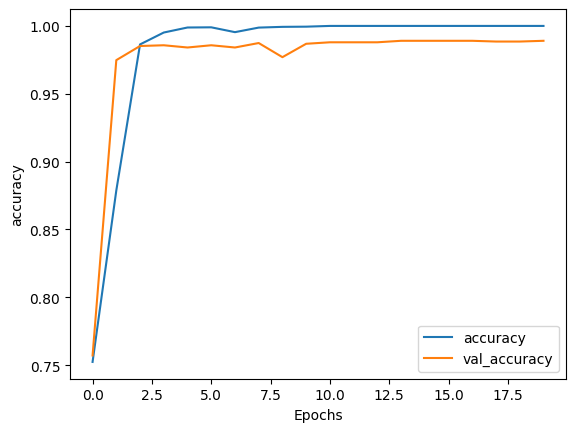

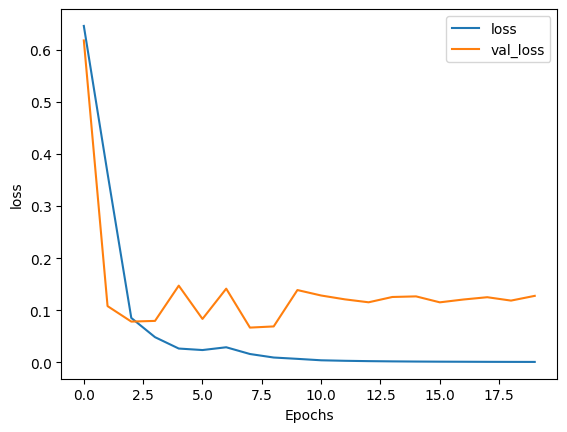

In [128]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')